# Bayesian seats model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Supporting-functions" data-toc-modified-id="Supporting-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Supporting functions</a></span></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Stan-Polling-to-2pp-model" data-toc-modified-id="Stan-Polling-to-2pp-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stan Polling to 2pp model</a></span></li><li><span><a href="#Stan-2pp-difference-to-seats-difference-conversion-model" data-toc-modified-id="Stan-2pp-difference-to-seats-difference-conversion-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Stan 2pp-difference to seats-difference conversion model</a></span><ul class="toc-item"><li><span><a href="#Estimate-with-Stan" data-toc-modified-id="Estimate-with-Stan-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Estimate with Stan</a></span></li><li><span><a href="#Cross-check-with-statsmodels" data-toc-modified-id="Cross-check-with-statsmodels-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Cross check with statsmodels</a></span></li></ul></li><li><span><a href="#Stan-seats-and-house-outcomes-model" data-toc-modified-id="Stan-seats-and-house-outcomes-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Stan seats and house outcomes model</a></span></li><li><span><a href="#Visualise-results" data-toc-modified-id="Visualise-results-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Visualise results</a></span><ul class="toc-item"><li><span><a href="#Get-samples" data-toc-modified-id="Get-samples-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Get samples</a></span></li><li><span><a href="#Seats-won" data-toc-modified-id="Seats-won-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Seats won</a></span></li><li><span><a href="#House-outcome" data-toc-modified-id="House-outcome-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>House outcome</a></span></li><li><span><a href="#Model-for-non-major-party-members" data-toc-modified-id="Model-for-non-major-party-members-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Model for non-major party members</a></span></li></ul></li></ul></div>

## Python setup

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import arviz as az
import stan # install with pip - conda is problematic on the M1 MBP

# system imports
import pathlib
import math

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER

In [2]:
# enable pystan on jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [3]:
# Package version numbers
print(f'Stan version: {stan.__version__}')
print(f'ArviZ version: {az.__version__}')
print(f'Statsmodels version: {sm.__version__}')

Stan version: 3.3.0
ArviZ version: 0.11.4
Statsmodels version: 0.13.1


In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

In [5]:
# data locations
SEAT_HISTORY_FILE = '../historical-data/Seat History.csv'

## Supporting functions

## Get the data

Note: the data was produced by the "capture wiki election history data and preliminary charts" notebook.

In [6]:
def fix_column_names(t: pd.DataFrame) -> pd.DataFrame:
    """Replace 'Unnamed' column names with ''."""
    
    replacements = {}
    for c in t.columns:
        if 'Unnamed' in c[1]:
            replacements[c[1]] = ''
    if replacements:
        t = t.rename(columns=replacements, level=1)
    return t

In [7]:
# Load historical elections data
seat_history = pd.read_csv(SEAT_HISTORY_FILE, header=[0, 1], 
                           index_col=0, parse_dates=[0], )
seat_history = fix_column_names(seat_history)
seat_history.index.dtype

dtype('<M8[ns]')

In [8]:
seat_history.columns

MultiIndex([(               'Primary vote',   'ALP'),
            (               'Primary vote',  'L+NP'),
            (               'Primary vote',  'Oth.'),
            (                   '2PP vote',   'ALP'),
            (                   '2PP vote',  'L+NP'),
            (                      'Seats',   'ALP'),
            (                      'Seats',  'L+NP'),
            (                      'Seats',  'Oth.'),
            (                      'Seats', 'Total'),
            ('Governing party at election',      ''),
            (            'Governing since',      ''),
            (             'PM at election',      ''),
            (              'Winning party',      ''),
            (                      'Notes',      ''),
            (             'log gov period',      ''),
            (                     'winner',      ''),
            (      'Govt 2pp votes margin',      ''),
            (          'Govt seats margin',      '')],
           )

In [9]:
seat_history['Proportion of others'] = (
    seat_history[('Seats',  'Oth.')] 
    / seat_history[('Seats', 'Total')]
)

In [10]:
# limit input data to recent history
HISTORY_START = 1969 # let's start with Don's party ...
seat_history = seat_history[seat_history.index.year >= HISTORY_START]

In [11]:
# limit autoregressive model of non-major party members to an even more recent period
seat_history['Row number'] = range(1, len(seat_history)+1)
AUTOREGRESS_FROM = 1993 # previous election non-zero, also subsequent also non-zero
assert(AUTOREGRESS_FROM >= HISTORY_START)
ar_from = seat_history.loc[seat_history.index.year == AUTOREGRESS_FROM, 'Row number'].values[0]
ar_from

11

In [12]:
len(seat_history)

20

## Stan Polling to 2pp model

Still to be written

In [13]:
# TO DO

## Stan 2pp-difference to seats-difference conversion model

### Estimate with Stan

In [14]:
conversion_data = {
    'n_history': len(seat_history),
    'seats': seat_history['Govt seats margin'].values,
    'votes': seat_history['Govt 2pp votes margin'].values,
}

In [15]:
conversion_model = """
data {
    int<lower=1> n_history;    // length of election history
    vector<lower=-1,upper=1>[n_history] seats;  // Coalition seats margin (response)
    vector<lower=-1,upper=1>[n_history] votes;  // Coalition votes margin (inputs)
}

parameters {
    // historical relationship between 2pp votes and seats
    real slope;
    real intercept;
    real<lower=0.000001> sigma; // force half cauchy with lower bound  
}

model {
    // priors on vote difference
    intercept ~ normal(0, 1);
    slope ~ normal(3, 1);      
    sigma ~ cauchy(0, 1);

    // linear regression from 2pp vote difference to seats difference
    // use student_t here for the fatter tails ...
    seats ~ student_t(5, intercept + (slope * votes), sigma); // fatter tails
    //seats ~ normal(intercept + (slope * votes), sigma); // normal dist.   
}

generated quantities {

    // --- MODEL DIAGNOSTICS ---
    
    // 2pp to seats relationship
    vector<lower=-1,upper=1>[n_history] seats_estimate;
    seats_estimate = slope * votes + intercept;
    
    // prediction interval on 2pp to seats relationship
    real<lower=-1,upper=1> predict_interval[n_history] = 
        normal_rng(intercept + (slope * votes), sigma);
}
"""

In [16]:
conv_posterior = stan.build(conversion_model, data=conversion_data)

# Note: Stan typically produces an ocean of compiler warnings.
#       For the most part these are utterly _useless_ warnings.
#       But there may be an important parser diagnostic that 
#       requres action buried among the blathering. Searching
#.      for "PARSER" and "DIAGNOSTIC" can help find if there is 
#.      something of concern.
#       https://mc-stan.org/misc/warnings.html#compiler-warnings

Building: found in cache, done.


In [17]:
conv_fit = conv_posterior.sample(num_chains=4, num_samples=25_000)

# Very occasionally generates an "inifity should be positive
# finite" Exception. These seem to be well managed. 
# They typically occur at less than one per 100,000 samples.

Sampling:   0%
Sampling:  25% (26000/104000)
Sampling:  50% (52000/104000)
Sampling:  75% (78000/104000)
Sampling: 100% (104000/104000)
Sampling: 100% (104000/104000), done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: student_t_lpdf: Scale parameter is inf, but must be positive finite! (in '/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/httpstan_zouy0i4y/model_bwek5t4l.stan', line 23, column 4 to column 61)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but 

In [18]:
az.summary(conv_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,3.352,0.310,2.757,3.933,0.001,0.001,80663.0,62200.0,1.0
intercept,0.036,0.017,0.004,0.068,0.000,0.000,79877.0,65861.0,1.0
sigma,0.064,0.014,0.041,0.090,0.000,0.000,70863.0,65202.0,1.0
seats_estimate[0],0.022,0.017,-0.010,0.055,0.000,0.000,78933.0,65017.0,1.0
seats_estimate[1],-0.145,0.026,-0.193,-0.097,0.000,0.000,74695.0,61241.0,1.0
seats_estimate[2],0.150,0.019,0.115,0.185,0.000,0.000,85718.0,63718.0,1.0
seats_estimate[3],0.418,0.037,0.348,0.487,0.000,0.000,86554.0,66853.0,1.0
seats_estimate[4],0.344,0.031,0.284,0.401,0.000,0.000,87516.0,67168.0,1.0
seats_estimate[5],0.063,0.017,0.031,0.094,0.000,0.000,81144.0,66466.0,1.0
seats_estimate[6],-0.179,0.028,-0.231,-0.125,0.000,0.000,74801.0,61527.0,1.0


array([[<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

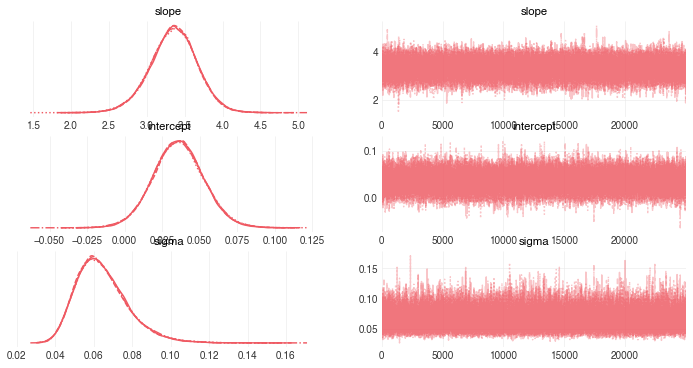

In [19]:
az.plot_trace(conv_fit, var_names=['slope', 'intercept', 'sigma',])

In [20]:
conv_results_df = conv_fit.to_frame()

In [21]:
# extract key variables for next step ...
conv_slope = conv_results_df['slope'].median()
conv_intercept = conv_results_df['intercept'].median()
conv_sigma = conv_results_df['sigma'].median()

# What is our conversion formula ...
conv_formula = (
    f'y = {round(conv_slope, 4)}x + {round(conv_intercept, 4)};  '
    f'σ = {round(conv_sigma, 4)}'
)
conv_formula

'y = 3.3591x + 0.0356;  σ = 0.0626'

In [22]:
quants = [0.005, 0.025, 0.100, 0.250, 0.500, 0.750, 0.900, 0.975, 0.995]
LOW = 'low'
HIGH = 'high'
ranges = pd.DataFrame({
    '99%': (0.005, 0.995),
    '95%': (0.025, 0.975),
    '80%': (0.100, 0.900),
    '50%': (0.250, 0.750),
}, index=[LOW, HIGH]).T
ranges

,low,high
99%,0.005,0.995
95%,0.025,0.975
80%,0.100,0.900
50%,0.250,0.750


In [23]:
def get_estimates_quants(pattern):

    # Get seat estimate quantiles
    seat_estimate = (
        conv_results_df[conv_results_df.columns[
            conv_results_df.columns.str.contains(pattern)
        ]]
    )
    seat_estimate.columns = seat_history.index
    seat_estimate = seat_estimate.quantile(quants).T

    # link to votes
    seat_estimate['2pp votes'] = seat_history['Govt 2pp votes margin']
    seat_estimate = seat_estimate.sort_values('2pp votes')
    
    return seat_estimate
        
estimates = get_estimates_quants('seats_estimate')

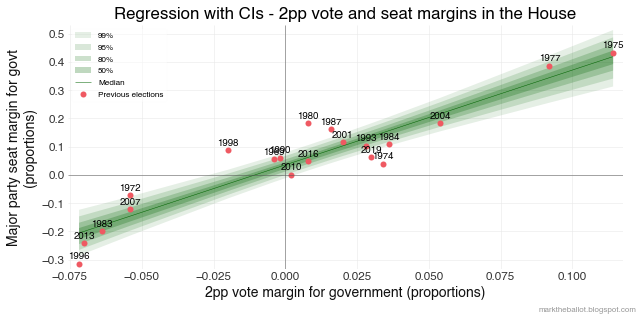

In [24]:
def plot_est_quants(estimates, title, **kwargs):
    # plot this relationship
    fig, ax = common.initiate_plot()
    alpha = 0.1
    for x, y in ranges.iterrows():
        low = y[0]
        high = y[1]
        lowpoint = estimates[low]
        highpoint = estimates[high]
        ax.fill_between(x=estimates['2pp votes'], y1=lowpoint, y2=highpoint,
                    color='darkgreen', alpha = alpha, label=x,)
        alpha += 0.05
    
    ax.plot(estimates['2pp votes'], estimates[0.500], 
        color='darkgreen', lw=0.5, label='Median')

    ax.scatter(seat_history['Govt 2pp votes margin'],
               seat_history['Govt seats margin'],
               label='Previous elections')

    ax.axhline(0, lw=0.5, color='#555555')
    ax.axvline(0, lw=0.5, color='#555555')

    for x, y, s in zip(seat_history['Govt 2pp votes margin'],
                       seat_history['Govt seats margin']+0.01,
                       seat_history.index.year.astype(str)):
        ax.text(x, y, s, fontsize='x-small', va='bottom', ha='center')
    

    ax.legend(loc='best')
    common.plot_finalise(ax, 
                  title=title,
                  xlabel='2pp vote margin for government (proportions)', 
                  ylabel='Major party seat margin for govt\n(proportions)',
                  **kwargs)

plot_est_quants(estimates, 
                'Regression with CIs - 2pp vote and seat margins in the House')

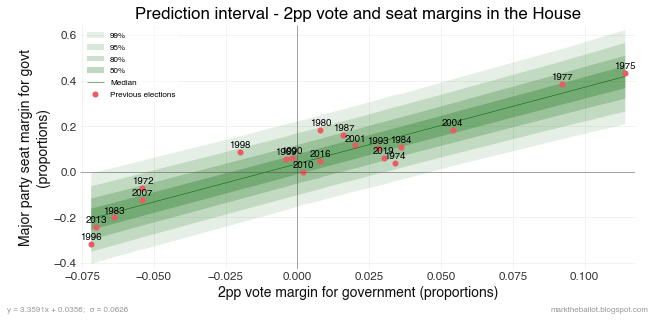

In [25]:
predictions = get_estimates_quants('predict_interval')
plot_est_quants(predictions, 
                'Prediction interval - 2pp vote and seat margins in the House',
                lfooter=conv_formula)

### Cross check with statsmodels

In [26]:
# ordinary least squares regression model
data = seat_history[['Govt seats margin', 
                     'Govt 2pp votes margin']].sort_values('Govt 2pp votes margin')
y = data['Govt seats margin'].values
x = data['Govt 2pp votes margin'].values
x_const = sm.add_constant(x) 
fitted = sm.OLS(y, x_const).fit() 
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     123.3
Date:                Mon, 29 Nov 2021   Prob (F-statistic):           1.74e-09
Time:                        14:54:48   Log-Likelihood:                 26.519
No. Observations:                  20   AIC:                            -49.04
Df Residuals:                      18   BIC:                            -47.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0369      0.015      2.421      0.026       0.005       0.069
x1             3.3900      0.305     11.103      0.000       2.749       4.031
==============================================================================
Omnibus:                        0.208   Durbin-Watson:                   0.958
Prob(Omnibus):                  0.901   Jarque-Bera (JB):                0.392
Skew:                           0.160   Prob(JB):                        0.822
Kurtosis:                       2.393   Cond. No.                         20.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# get the prediction interval
pred_std_error, lower_pred, upper_pred = wls_prediction_std(fitted, exog=x_const)
pred_std_error.min(), pred_std_error.mean(), pred_std_error.max()

(0.06940842230698828, 0.07100696443153251, 0.07695599456892749)

## Stan seats and house outcomes model

In [28]:
SEATS_NEXT_PARLIAMENT = 151
WIN_THRESHOLD = 75.5 # which will round up to 76 ...
seats_data = {

    'tpp': 0.464, # Still to code a polling model

    'conv_slope': conv_slope,
    'conv_intercept': conv_intercept,
    'conv_sigma': conv_sigma,
    
    'n_seats': SEATS_NEXT_PARLIAMENT,
    'n_history': len(seat_history),
    'win_threshold': WIN_THRESHOLD,
    'others': seat_history['Proportion of others'].values,
    'ar_from': ar_from,
}
tpp_footer = f'Coalition 2pp = {seats_data["tpp"]}'

In [29]:
seats_model = """
data {

    // input from the polling model
    real<lower=0,upper=1> tpp; // STILL TO CODE: from polls to tpp

    // input from the conversion model
    real conv_slope;
    real conv_intercept;
    real<lower=0.000001> conv_sigma; // must be non-zero positive

    // inputs for this model
    int<lower=1> n_seats;     // number of seats in parliament next election
    real<lower=0,upper=n_seats> win_threshold; // account for rounding to ints
    int<lower=1> n_history;    // length of election history
    vector<lower=0,upper=1>[n_history] others;
    int<lower=1> ar_from;
}

parameters {
    // auto regressive, this year is much like last year
    real drift;
    real replication;
    real<lower=0.000001> s; // force half cauchy with lower bound
}

model {
    // priors on auto-regressive non-major-party seat proportion
    // --- this is not a great model in the circumstances
    drift ~ normal(0.0, 0.1);     // informative prior
    replication ~ normal(1, 0.1); // informative prior
    s ~ cauchy(0, 10);

    // limited autoregressive(1) model over recent data
    // for proportion of non-major-party seats
    others[ar_from:n_history] ~  
        normal(drift + (replication * others[(ar_from-1):(n_history-1)]), s);
}

generated quantities {

    // --- 2022 FORECAST ---

    // seats won by other parties
    real<lower=0,upper=n_seats> other_seats = 
        (drift + (replication * others[n_history])) * n_seats;

    // seats remaining available for the Coalition and Labor
    real<lower=0,upper=n_seats> available_seats = n_seats - other_seats;

    // Given the Coalition's TPP, how many seats will the Coalition/Govt win?
    // Note: regression based on student_t, but prediction is from normal.
    real seats_forecast = 
        normal_rng(conv_slope * (tpp - (1 - tpp)) + conv_intercept, conv_sigma);
    
    real<lower=0,upper=n_seats> government_seats = 
        (available_seats / 2)
        + (seats_forecast * (available_seats / 2));

    // Labor seats = total seats - other seats - Coalition seats
    real<lower=0,upper=n_seats> opposition_seats = 
        (available_seats - government_seats);

    // How often does the Coalition government win the election?
    int<lower=0,upper=1> government_wins = government_seats > win_threshold ? 1 : 0;

    // How often does the Labor opposition win?
    int<lower=0,upper=1> opposition_wins = opposition_seats > win_threshold ? 1 : 0;
    
    // How often do we get a hung parliament?
    int<lower=0,upper=1> hung_parliament = 
        (government_wins == 0 && opposition_wins == 0) ? 1 : 0;
}
"""

In [30]:
posterior = stan.build(seats_model, data=seats_data)

# See note above about Stan warnings

Building: found in cache, done.


In [31]:
# This step takes between 1 and 2 minutes ...

SEATS_SAMPLES = 25_000
SEATS_CHAINS = 4
fit = posterior.sample(num_chains=SEATS_CHAINS, 
                       num_samples=SEATS_SAMPLES, )

# Note: Very occasionally, sampling produces one or two exceptions.
#       This should not be of too much concern, provided 
#       the total number is less than a handful. Not sure 
#       why, but the negative number exceptions result in 
#       garbage samples. We will fix this below.

Sampling:   0%
Sampling:  25% (26000/104000)
Sampling:  50% (52000/104000)
Sampling:  75% (78000/104000)
Sampling: 100% (104000/104000)
Sampling: 100% (104000/104000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!


In [32]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
drift,0.004,0.006,-0.008,0.016,0.000,0.000,61472.0,57810.0,1.0
replication,0.960,0.099,0.770,1.145,0.000,0.000,61654.0,58269.0,1.0
s,0.018,0.005,0.010,0.027,0.000,0.000,53287.0,49737.0,1.0
other_seats,6.390,0.907,4.692,8.125,0.003,0.002,75500.0,58410.0,1.0
available_seats,144.610,0.907,142.875,146.308,0.003,0.002,75500.0,58410.0,1.0
seats_forecast,-0.207,0.063,-0.326,-0.090,0.000,0.000,100476.0,99005.0,1.0
government_seats,57.365,4.560,48.665,65.832,0.014,0.010,100032.0,98826.0,1.0
opposition_seats,87.246,4.579,78.647,95.890,0.014,0.010,100305.0,98540.0,1.0
government_wins,0.000,0.006,0.000,0.000,0.000,0.000,100023.0,100023.0,1.0
opposition_wins,0.995,0.071,1.000,1.000,0.000,0.000,98751.0,100000.0,1.0


/Users/bryanpalmer/miniconda3/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<AxesSubplot:title={'center':'drift'}>,
        <AxesSubplot:title={'center':'drift'}>],
       [<AxesSubplot:title={'center':'replication'}>,
        <AxesSubplot:title={'center':'replication'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>],
       [<AxesSubplot:title={'center':'other_seats'}>,
        <AxesSubplot:title={'center':'other_seats'}>],
       [<AxesSubplot:title={'center':'government_seats'}>,
        <AxesSubplot:title={'center':'government_seats'}>],
       [<AxesSubplot:title={'center':'opposition_seats'}>,
        <AxesSubplot:title={'center':'opposition_seats'}>],
       [<AxesSubplot:title={'center':'government_wins'}>,
        <AxesSubplot:title={'center':'government_wins'}>],
       [<AxesSubplot:title={'center':'opposition_wins'}>,
        <AxesSubplot:title={'center':'opposition_wins'}>],
       [<AxesSubplot:title={'center':'hung_parliament'}>,
        <AxesSubplot:title={'center':'hung_parliament'}>]], dtype=

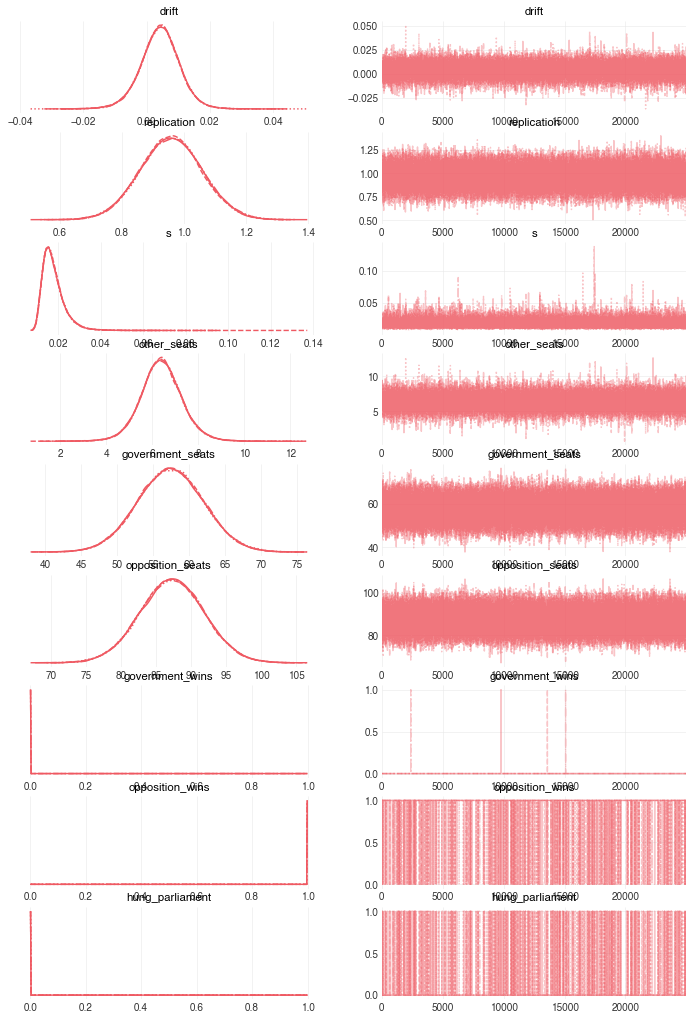

In [33]:
az.plot_trace(fit, var_names=['drift', 'replication', 's',
                              'other_seats', 'government_seats',
                              'opposition_seats', 'government_wins',
                              'opposition_wins', 'hung_parliament'])

## Visualise results

### Get samples

In [34]:
# Get our samples in a DataFrame
results_df = fit.to_frame()

# Let's drop any problematic samples that might have come about 
# as a result of any negative value exceptions (as noted above)
# Still not clear why this happens.
bad = results_df['government_seats'] == 0
if bad.sum() > 0:
    print(f'About to drop {bad.sum()} sample{"s" if bad.sum() > 1 else ""}')
results_df = results_df[~bad]
len(results_df) # remaining samples after removing the problematic ones (if any)

100000

In [35]:
# Check if the problem of bad samples has occurred too many times. 
#       I want it to occur in less than 1 in 10,000 samples.
THRESHOLD = 10_000
CHECK_TOO_MANY = int((SEATS_SAMPLES * SEATS_CHAINS) / THRESHOLD)
if bad.sum() > CHECK_TOO_MANY:
    print(f'Problem if deletions exceed this threshold: {CHECK_TOO_MANY}')
assert (SEATS_SAMPLES * SEATS_CHAINS) - CHECK_TOO_MANY < len(results_df)

### Seats won

In [36]:
def plot_seats_won(party, title, colour):
    sw = results_df[party].round(0).value_counts()
    sw = sw.sort_index() / sw.sum()
    outright_win = sw[sw.index > WIN_THRESHOLD].sum() / sw.sum()
    lfooter = f'Outright win probability = {round(outright_win, 5)}; {tpp_footer}'
    sw.index = sw.index.astype(int)
    _, ax = common.initiate_plot()
    ax.bar(x=sw.index, height=sw, color=colour)
    
    xlim = ax.get_xlim()
    if xlim[0] < WIN_THRESHOLD < xlim[1]:
        ax.axvline(WIN_THRESHOLD, lw=0.5, c='b')
    
    common.plot_finalise(ax, title,
                  xlabel='Number of seats won',
                  ylabel='Probability',
                  lfooter=lfooter, )

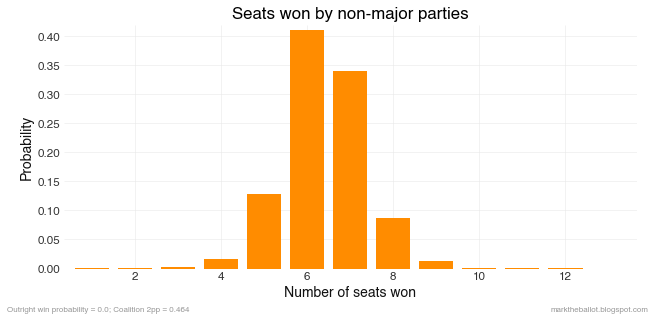

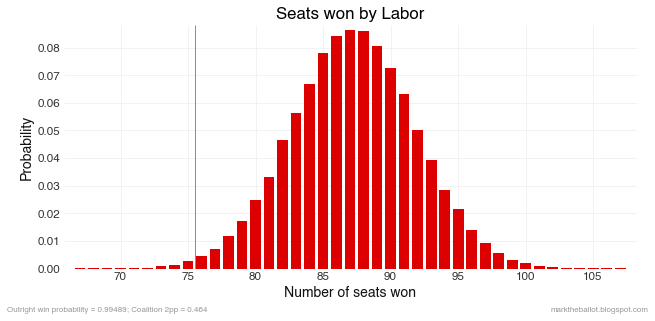

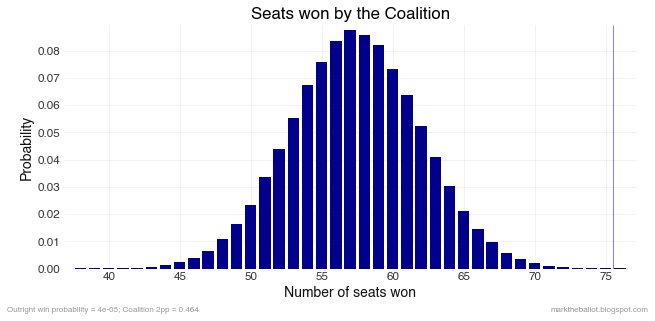

In [37]:
plot_seats_won('other_seats', 'Seats won by non-major parties', COLOR_OTHER)
plot_seats_won('opposition_seats', 'Seats won by Labor', COLOR_LABOR)
plot_seats_won('government_seats', 'Seats won by the Coalition', COLOR_COALITION)

### House outcome

parameters
Labour Wins Outright       0.99489
Hung Parliament            0.00507
Coalition Wins Outright    0.00004
dtype: float64


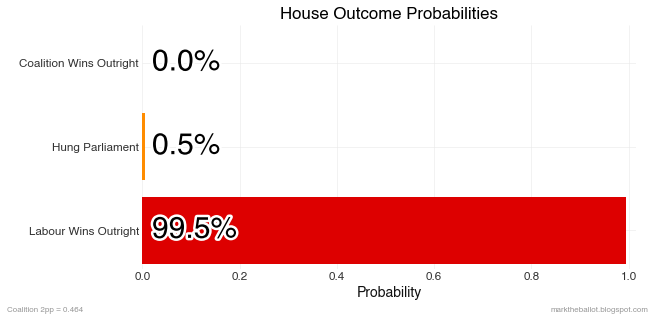

In [38]:
# probabilities for the types of house outcomes
def plot_house_probabilities():
    ho = results_df[['government_wins', 'opposition_wins', 'hung_parliament']].sum()
    renamer = {
        'opposition_wins': 'Labour Wins Outright',
        'hung_parliament': 'Hung Parliament',
        'government_wins': 'Coalition Wins Outright',
    }
    ho = ho.rename(index=renamer)
    order = list(renamer.values())
    ho = (ho / ho.sum())[order]
    print(ho) # more detail than the rounded version in the charts. 
    _, ax = common.initiate_plot()
    colors = [COLOR_LABOR, COLOR_OTHER, COLOR_COALITION, ]
    ax.barh(ho.index, ho, color=colors)
    for index, value in ho.iteritems():
        text = ax.text(x=0.02, y=index, s=f'{round(value*100, 1)}%', 
                fontsize=30, ha='left', va='center')
        text.set_path_effects([pe.withStroke(linewidth=5, foreground='w')])
    common.plot_finalise(ax, 'House Outcome Probabilities',
                  ylabel=None,
                  xlabel='Probability',
                  lfooter=tpp_footer, 
                 )
    
plot_house_probabilities()

adjusting up


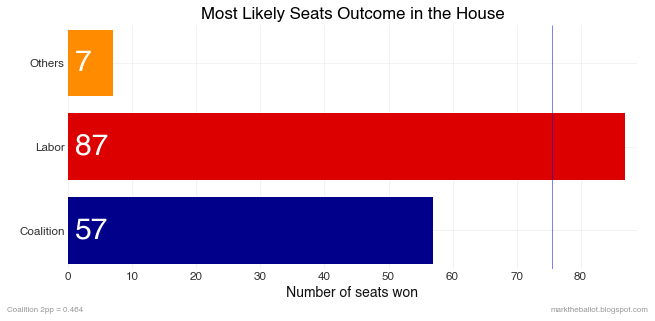

In [39]:
# Most likely house outcome
def plot_likely_house_seats_outcome():
    parties = ['government_seats', 'opposition_seats', 'other_seats']
    xparties = ['Coalition', 'Labor', 'Others']
    bar_dict = {}
    for p, x in zip(parties, xparties):
        bar_dict[x] = results_df[p].median()
    series = pd.Series(bar_dict)

    # check for jankie rounding errors
    rounded = series.round(0).astype(int)
    if rounded.sum() < SEATS_NEXT_PARLIAMENT:
        print('adjusting up')
        bless = (
            (series + 0.5)
            .apply(lambda a: math.modf(a)[0])
            .sort_values(ascending=False).index[0]
        )
        rounded[bless] = rounded[bless] + 1
    if rounded.sum() > SEATS_NEXT_PARLIAMENT:
        print('adjusting down')
        bless = (
            (series - 0.5)
            .apply(lambda a: math.modf(a)[0])
            .sort_values(ascending=True).index[0]
        )
        rounded[bless] = rounded[bless] - 1

    # plot
    fig, ax = common.initiate_plot()
    colors = [COLOR_COALITION, COLOR_LABOR, COLOR_OTHER]
    ax.barh(rounded.index, rounded, color=colors)
    ax.axvline(WIN_THRESHOLD, lw=0.5, c='b')

    for index, value in rounded.iteritems():
        ax.text(x=1, y=index, s=str(value), c='w', fontsize=30,
                ha='left', va='center')

    common.plot_finalise(ax, 
                  title='Most Likely Seats Outcome in the House',
                  xlabel='Number of seats won',
                  ylabel=None,
                  lfooter=tpp_footer)

plot_likely_house_seats_outcome()

### Model for non-major party members

Trend over recent years has been increasing representation, but overall, this year's numbers are much like last years. At hthe moment, this modelled with autoregressive(1) model.

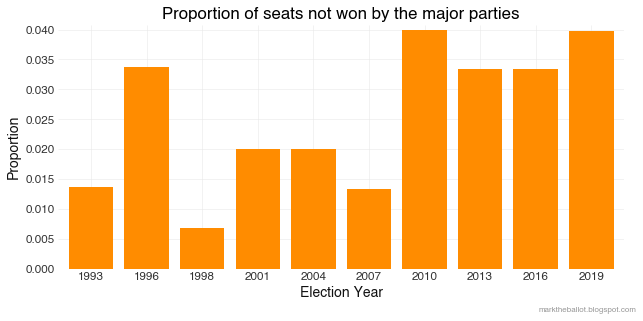

In [40]:
# Historical data as a bar chart
def plot_historical_other():
    data = seat_history.loc[seat_history['Row number'] >= ar_from, 
                            'Proportion of others']
    fig, ax = common.initiate_plot()
    ax.bar(x=[str(x) for x in data.index.year],
           height=data.values, color=COLOR_OTHER)

    common.plot_finalise(ax, 
                  title='Proportion of seats not won by the major parties',
                  xlabel='Election Year', 
                  ylabel='Proportion',)

plot_historical_other()